# re-analysis of Aei editing from main cohort, brain sequencing data from Sorce et al. 2020

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os

#### read metadata

In [4]:
brMeta=pd.read_excel("./sourceData/p3507_BrainSamples.xlsx")

In [184]:
brMeta.columns=['seqID','sampleID','genotype','treatment','wpi','region','cohort']

#### read aei

In [185]:
brAei=pd.read_csv("./sourceData/AeiBrain.csv") # read first aei output
brAei.drop(0,axis=0,inplace=True) # rm pb-11 from first output, was empty
brPb11=pd.read_csv("./sourceData/AeiBrainPb11.csv")
brAei=brAei.append(brPb11)
brAei.reset_index(inplace=True,drop=True)

In [186]:
brAei['Sample']=brAei['Sample'].str.split("A",expand=True)[1] # harmonize sample names
brAei['Sample']=brAei['Sample'].str[1:]
brAei['Sample']=brAei['Sample']+"_Hp"

In [187]:
br=brAei.merge(brMeta,left_on="Sample",right_on="sampleID") # merge Aei with metadata

In [188]:
br['wpi'].loc[br['wpi']=="term"]=22 # change term to 22
# change wpi to int64
br['wpi']=br['wpi'].astype("int64")

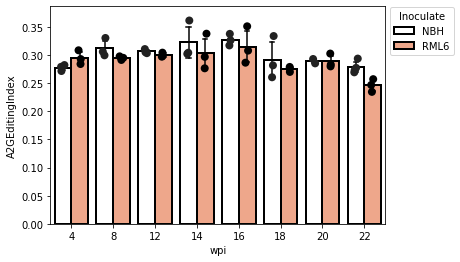

In [189]:
# plot term wpi
tips = br
palette=[color for color in ["white","lightsalmon"]*8] 
hue_order=["NBH","RML6"]
ax = sns.barplot(
    x='wpi',
    y='A2GEditingIndex',
    hue='treatment',
    data=tips, 
    ci="sd", 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.1,
    alpha=1,
    linewidth=2,
    hue_order=hue_order,
    palette=palette
)

sns.stripplot(
     x='wpi',
    y='A2GEditingIndex',
    hue='treatment',
    hue_order=hue_order,
    data=tips, dodge=True, alpha=1, size=8, color="black",ax=ax
)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
#ax.set(ylim=(0,1))
ax.legend(handles[2:], labels[2:], title='Inoculate', bbox_to_anchor=(1, 1.02), loc='upper left')
#ax.figure.savefig('muscle_AEI.png',bbox_inches="tight")

In [190]:
# calculate p values

from statsmodels.stats.multitest import multipletests # for fdr
from scipy.stats import ttest_ind # for t - test
import numpy as np
wpiUnique=br['wpi'].unique()

# two-sided t-test for test per wpi
tT=pd.DataFrame({'wpi':[],'pValue':[]}) # preassign dataframe

for i in range(0,len(wpiUnique)):
    tTtemp=pd.DataFrame({'wpi':np.ones(1),'sig':np.ones(1),'fdr':np.ones(1),'pValue':np.ones(1)})
    tTtemp[['sig','fdr']]=[1,1]
    tTtemp['wpi']=wpiUnique[i]
    aeiNbhTemp=br['A2GEditingIndex'].loc[(br['wpi']==wpiUnique[i]) & (br['treatment']=="NBH")]
    aeiRmlTemp=br['A2GEditingIndex'].loc[(br['wpi']==wpiUnique[i]) & (br['treatment']=="RML6")]
    tTtemp['pValue']=ttest_ind(aeiNbhTemp,aeiRmlTemp)[1]
    tT=tT.append(tTtemp)
tT.reset_index(inplace=True)


In [191]:
tT['sig']=multipletests(tT['pValue'],alpha=0.05,method="fdr_bh")[0]
tT['fdr']=multipletests(tT['pValue'],alpha=0.05,method="fdr_bh")[1]

In [192]:
tT

,index,fdr,pValue,sig,wpi
0,0,0.095110,0.011889,False,22.0
1,0,0.667177,0.517830,False,14.0
2,0,0.289117,0.144558,False,8.0
3,0,0.667177,0.485654,False,18.0
4,0,0.667177,0.583780,False,16.0
5,0,0.281909,0.088534,False,4.0
6,0,0.956116,0.956116,False,20.0
7,0,0.281909,0.105716,False,12.0
